# Predicting fluxes from transcripts using a neural network

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict, ShuffleSplit
from tpot import TPOTRegressor
import seaborn as sns
import random, copy, torch
import torch.utils.data as utils_data
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time, os, random
import torch.nn.functional as F
import torch.nn.init as init
import cobra, math
from scipy.optimize import minimize
np.set_printoptions(precision=4, linewidth=180)
%matplotlib inline

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load input files

In [2]:
# Load reaction names
reactionNames = np.loadtxt('ishii-flux-names.csv',delimiter=',', skiprows=0,usecols=0,dtype='str')

In [3]:
# Load metabolic model
cModel = cobra.io.read_sbml_model('iJO1366.xml')

In [4]:
# Select flux indicies for plotting
reactionDict = {'PGI':2076,'PFK':2063,'FBA':1150,'TPI':2455,'PYK':2265,'PDH':2046,'GND':1422,'RPE':2311,'RPI':2312,'TALA':2397,'ICL':1551,'MALS':1713}
ishiiDict = {2076:2.247179186,2063:2.495301258,1150:2.495301258,2455:2.495301258,2265:1.399624166,2046:3.722827564,1422:.6439079794,2311:.2684455913,2312:.3754514687,2397:.1783978343,1551:.3268244693,1713:.3268244693}

In [5]:
# Load train and test data
# Training data is from eflux2 samples 2 to 8, representing different KEIO KO strains and growth conditions
# Test data is eflux2 sample1, the WT reference sample
train_x, train_y = [],[]
for i in range(2,9):
    train_x.append(np.loadtxt('ishii-trans-'+str(i)+'.csv',delimiter=',',skiprows=0,usecols=1))
    train_y.append(np.loadtxt('ishii-flux-'+str(i)+'.csv'))
test_x, test_y = np.loadtxt('ishii-trans-1.csv',delimiter=',',skiprows=0,usecols=1),np.loadtxt('ishii-flux-1.csv')
train_x, train_y = np.array(train_x), np.array(train_y)

# Define and run neural network

In [6]:
use_cuda = torch.cuda.is_available()

In [7]:
# Set up data type for torch and metabolic model
print('Will we use cuda?',use_cuda)
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

# Define number of steps for NN to learn, the longer the better except for overfitting
#num_steps = 4000000 #  requires a GPU cluster
num_steps = 500

# Convert metabolic model to tensor
my_matrix =Variable((torch.from_numpy( np.array(cobra.util.array.create_stoichiometric_matrix(cModel))).type(dtype)))

Will we use cuda? False


Define neural network class

In [8]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        width_start = 4110
        width = 101
        width_end = 1
        self.fclin1 = torch.nn.Linear(width_start,width)   #in, out numbers
        self.fclin2 = torch.nn.Linear(width, width)        #in, out numbers
        self.fclin3 = torch.nn.Linear(width, width)        #in, out numbers
        self.fclin4 = torch.nn.Linear(width, width)        #in, out numbers
        self.fclin5 = torch.nn.Linear(width, width)        #in, out numbers
        self.fclin6 = torch.nn.Linear(width, width)        #in, out numbers
        self.fclin7 = torch.nn.Linear(width, width)        #in, out numbers
        self.fclin8 = torch.nn.Linear(width, width)        #in, out numbers
        self.fclin9 = torch.nn.Linear(width, width)        #in, out numbers
        self.fclin10 = torch.nn.Linear(width, width)       #in, out numbers
        self.fclin11 = torch.nn.Linear(width, width)       #in, out numbers
        self.fclin12 = torch.nn.Linear(width, width)       #in, out numbers
        self.fclin13 = torch.nn.Linear(width, width)       #in, out numbers
        self.fclin14 = torch.nn.Linear(width, width)       #in, out numbers
        self.fclin15 = torch.nn.Linear(width, width_end)   #in, out numbers
        self.reluNN1 =  torch.nn.LeakyReLU(inplace=True)
        self.reluNN2 =  torch.nn.LeakyReLU(inplace=True)
        self.reluNN3 =  torch.nn.LeakyReLU(inplace=True)
        self.reluNN4 =  torch.nn.LeakyReLU(inplace=True)
        self.reluNN5 =  torch.nn.LeakyReLU(inplace=True)
        self.reluNN6 =  torch.nn.LeakyReLU(inplace=True)
        self.reluNN7 =  torch.nn.LeakyReLU(inplace=True)
        self.reluNN8 =  torch.nn.LeakyReLU(inplace=True)
        self.reluNN9 =  torch.nn.LeakyReLU(inplace=True)
        self.reluNN10 = torch.nn.LeakyReLU(inplace=True)
        self.reluNN11 = torch.nn.LeakyReLU(inplace=True)
        self.reluNN12 = torch.nn.LeakyReLU(inplace=True)
        self.reluNN13 = torch.nn.LeakyReLU(inplace=True)
        self.reluNN14 = torch.nn.LeakyReLU(inplace=True)
        self.reluNN15 = torch.nn.LeakyReLU(inplace=True)
    def forward(self, inp):
        net = self.reluNN1(self.fclin1(inp))
        net = self.reluNN2(self.fclin2(net))
        net = self.reluNN3(self.fclin3(net))
#        net = self.reluNN4(self.fclin4(net))
#        net = self.reluNN5(self.fclin5(net))
#        net = self.reluNN6(self.fclin6(net))
#        net = self.reluNN7(self.fclin7(net))
#        net = self.reluNN8(self.fclin8(net))
#        net = self.reluNN9(self.fclin9(net))
#        net = self.reluNN10(self.fclin10(net))
#        net = self.reluNN11(self.fclin11(net))
#        net = self.reluNN12(self.fclin12(net))
#        net = self.reluNN13(self.fclin13(net))
#        net = self.reluNN14(self.fclin14(net))
        net = self.reluNN15(self.fclin15(net))
        return net

class Regress_Loss(torch.nn.Module):

    def __init__(self):
        super(Regress_Loss,self).__init__()

    def forward(self,x,y):
        a = torch.mm(my_matrix,x)
        loss = torch.dot(a,a)
        return loss

Run NN

In [9]:
dim = 1 # dimensionality of input data
nnPredictions, eflux2, absError = [],[],[]
for r in range(len(reactionNames)):
    print('Working on reaction:',reactionNames[r])

    # Define working variables
    x = train_x
    y = train_y[:,r]
    print(y)
    y = np.transpose(np.array([y]))
    xmin = x.min()
    xmax = x.max()
    ymin = y.min()
    ymax = y.max()

    # Normalize data for a NN
    x = ( (x - xmin) / (xmax - xmin) )
    y = (y - ymin) / (ymax - ymin)
    x_test = np.transpose(test_x)
    y_test = np.transpose(test_y[r])
    print(y_test)
    x_test = ( (x_test - xmin) / (xmax - xmin) )
    y_test = (y_test - ymin) / (ymax - ymin)

    # Convert data to tensor
    x = Variable(torch.from_numpy(x).type(dtype))
    y = Variable(torch.from_numpy(y).type(dtype))
    x_test = Variable(torch.from_numpy(np.array([x_test])).type(dtype))
    y_test = Variable(torch.from_numpy(np.array([y_test])).type(dtype))

    # Set up some hyperparameters
    model = Model()
    criterion = torch.nn.SmoothL1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.00001)
    loss2 = []

    # Do back propagation on NN
    for i in range(num_steps):
        optimizer.zero_grad()
        loss =  criterion(model(x), y)
        loss2.append(loss.data[0])
#        if i%50==0:
#            print('Step',i,'|  loss=',loss.data[0])
#            print('   Predicted Y test',model(x_test),' |  Actual Y test',y_test)
        loss.backward()
        optimizer.step()
    print('Step',i,'|  loss=',loss.data[0])
    predict = model(x_test).data.numpy().reshape(-1,1)[0]
    predict = (ymax-ymin)*predict
    predict = ymin+predict
    nnPredictions.append(predict[0])
    print('   Neural Network:',predict[0],'|   Eflux2 prediction:',test_y[r])
    eflux2.append(float(test_y[r]))
    if math.isnan(predict[0]):
        predict[0] = 0.0
    absError.append(abs(predict[0]-float(test_y[r])))
    del model
    del x,y,x_test,y_test

Working on reaction: R_DM_4CRSOL
[8.08e-05 5.99e-05 6.23e-05 7.87e-05 5.74e-05 8.40e-05 6.11e-05]
7.47e-05


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:41 UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:47 UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Step 499 |  loss= tensor(1.00000e-02 *
       7.2511)
   Neural Network: 6.8602436e-05 |   Eflux2 prediction: 7.47e-05
Working on reaction: R_DM_5DRIB
[8.15e-05 6.04e-05 6.28e-05 7.94e-05 5.80e-05 8.48e-05 6.16e-05]
7.53e-05
Step 499 |  loss= tensor(1.00000e-02 *
       6.1006)
   Neural Network: 6.9564725e-05 |   Eflux2 prediction: 7.53e-05
Working on reaction: R_DM_AACALD
[1.48e-15 2.20e-15 1.59e-15 9.17e-16 1.58e-15 2.78e-15 1.96e-16]
8.65e-16
Step 499 |  loss= tensor(1.00000e-02 *
       4.2875)
   Neural Network: 1.5020343e-15 |   Eflux2 prediction: 8.65e-16
Working on reaction: R_DM_AMOB
[7.24e-07 5.37e-07 5.59e-07 7.06e-07 5.15e-07 7.54e-07 5.48e-07]
6.7e-07
Step 499 |  loss= tensor(1.00000e-02 *
       7.3217)
   Neural Network: 6.152263e-07 |   Eflux2 prediction: 6.7e-07
Working on reaction: R_DM_MTHTHF
[0.0002 0.0001 0.0001 0.0002 0.0001 0.0002 0.0001]
0.00015
Step 499 |  loss= tensor(1.00000e-02 *
       7.0530)
   Neural Network: 0.00013793187 |   Eflux2 prediction: 0.00015

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:18 RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:23 RuntimeWarning: invalid value encountered in double_scalars


Step 499 |  loss= tensor(nan.)
   Neural Network: nan |   Eflux2 prediction: 0.0
Working on reaction: R_EX_15dap_LPAREN_e_RPAREN_
[1.91e-15 2.28e-15 1.87e-15 1.14e-15 2.06e-15 3.65e-15 2.98e-16]
1.03e-15
Step 499 |  loss= tensor(1.00000e-02 *
       3.8800)
   Neural Network: 1.8311326e-15 |   Eflux2 prediction: 1.03e-15
Working on reaction: R_EX_23camp_LPAREN_e_RPAREN_
[1.72e-16 2.13e-16 1.63e-16 8.18e-17 1.46e-16 2.57e-16 8.81e-17]
3.38e-16
Step 499 |  loss= tensor(1.00000e-02 *
       5.3069)
   Neural Network: 1.5724598e-16 |   Eflux2 prediction: 3.38e-16
Working on reaction: R_EX_23ccmp_LPAREN_e_RPAREN_
[2.44e-16 3.03e-16 2.35e-16 1.28e-16 2.02e-16 4.00e-16 8.45e-17]
2.92e-16
Step 499 |  loss= tensor(1.00000e-02 *
       4.5942)
   Neural Network: 2.239332e-16 |   Eflux2 prediction: 2.92e-16
Working on reaction: R_EX_23cgmp_LPAREN_e_RPAREN_
[1.53e-16 1.93e-16 1.47e-16 7.29e-17 1.32e-16 2.31e-16 7.13e-17]
2.36e-16
Step 499 |  loss= tensor(1.00000e-02 *
       5.4729)
   Neural Netw

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:23 RuntimeWarning: divide by zero encountered in double_scalars


Step 499 |  loss= tensor(nan.)
   Neural Network: nan |   Eflux2 prediction: -1.42e-14
Working on reaction: R_FA100ACPHi
[4.03e-15 4.74e-15 3.86e-15 1.42e-15 2.57e-15 4.56e-15 4.11e-12]
1.56e-11
Step 499 |  loss= tensor(1.00000e-02 *
       2.1936)
   Neural Network: 4.7016215e-16 |   Eflux2 prediction: 1.56e-11
Working on reaction: R_FA120ACPHi
[3.18e-15 3.80e-15 3.10e-15 1.14e-15 2.06e-15 3.66e-15 3.22e-12]
1.2e-11
Step 499 |  loss= tensor(1.00000e-02 *
       2.2679)
   Neural Network: 4.0758167e-17 |   Eflux2 prediction: 1.2e-11
Working on reaction: R_FA140ACPHi
[3.44e-15 4.12e-15 3.35e-15 1.23e-15 2.23e-15 3.96e-15 3.47e-12]
1.29e-11
Step 499 |  loss= tensor(1.00000e-02 *
       1.8541)
   Neural Network: -1.3834399e-16 |   Eflux2 prediction: 1.29e-11
Working on reaction: R_FA141ACPHi
[3.46e-15 4.13e-15 3.36e-15 1.24e-15 2.24e-15 3.97e-15 3.50e-12]
1.3e-11
Step 499 |  loss= tensor(1.00000e-02 *
       3.4428)
   Neural Network: 3.7487964e-14 |   Eflux2 prediction: 1.3e-11
Working 

In [10]:
# Load reaction labels
labels=[i for i in reactionDict]

In [11]:
# Remove NaN floating point predictions for NN output
nnPredictions = [0.0 if math.isnan(x) else x for x in nnPredictions]
absError = [0.0 if math.isnan(x) else x for x in absError]

# Plot results

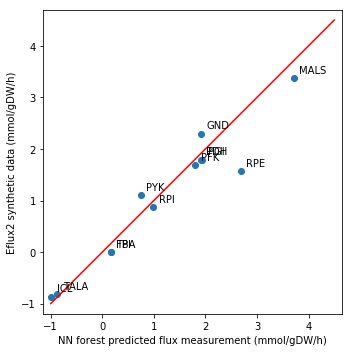

In [12]:
# Get data
nnPlot, eflux2Plot = [], []
for i in range(len(reactionNames)):
    if i in ishiiDict:
        nnPlot.append(nnPredictions[i])
        eflux2Plot.append(eflux2[i])
        
# Plot scatter plot of fluxes
plt.rcParams['figure.figsize'] = (5,5)
plt.scatter(nnPlot,eflux2Plot,label=labels)
X_plot = np.linspace(-1, 4.5, 100)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='r')
plt.xlim(-1,3)
plt.axis('equal')
for i in range(len(nnPlot)):
    xy = (nnPlot[i]+.1,eflux2Plot[i]+.1)
    plt.annotate(labels[i],xy)
plt.xlabel(r'NN forest predicted flux measurement (mmol/gDW/h)')
plt.ylabel(r'Eflux2 synthetic data (mmol/gDW/h)')
plt.tight_layout()
#plt.show()
plt.savefig('nn-eflux2-allReactions.pdf')

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462 UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.


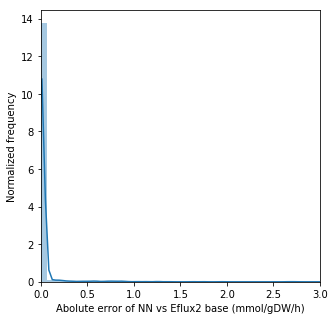

In [13]:
# Histogram plot of errors
g=sns.distplot(absError,hist=True)
plt.xlabel(r'Abolute error of NN vs Eflux2 base (mmol/gDW/h)')
plt.ylabel(r'Normalized frequency')
plt.xlim(0,3)
#plt.show()
plt.savefig('nn-eflux2-allReactions-error.pdf')

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462 UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.


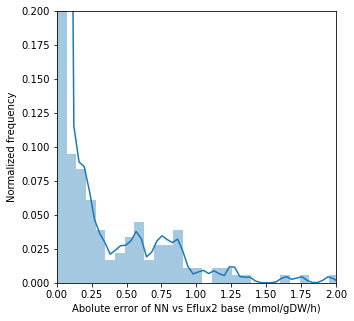

In [14]:
# Zoom of histogram error
g=sns.distplot(absError,hist=True)
plt.xlabel(r'Abolute error of NN vs Eflux2 base (mmol/gDW/h)')
plt.ylabel(r'Normalized frequency')
plt.xlim(0,2)
plt.ylim(0,.2)
#plt.show()
plt.savefig('nn-eflux2-error-allReactions-zoom.pdf')

Find optimal stoichiometric nudge:

In [15]:
xf = np.transpose(nnPredictions)
x0 = np.zeros(len(test_y))+.000005

# Weight factor for relative importance of Sv over the length of the nudging vector= b
weightFactor = 1000.0
print('Initial ||Sv|| = ',np.dot(np.matmul(my_matrix,xf),np.matmul(my_matrix,xf)))
print('   Now find nudging vector minimizeResult.x which reduces Sv to zero')

def rosen(x):
    adjusted_fluxes =xf[:]-x[:]
    a = np.matmul(my_matrix,adjusted_fluxes)
    Sloss = np.dot(a,a)*weightFactor
    bLength = sum((x[:])**2)
    
    # Get occasional updates on solver progress
    if np.random.rand()<.001:
        print('||S(v-b)||=',Sloss/weightFactor,', ||b||=',bLength)
    return bLength + Sloss

# Minimize f = ||S(v-b)||*weightFactor + ||b||
minimizeResult = minimize(rosen, x0, method='BFGS', options={'disp': True})

Initial ||Sv|| =  3.567641024463813
   Now find nudging vector minimizeResult.x which reduces Sv to zero
||S(v-b)||= 3.56961891681589 , ||b||= 6.457514923365838e-08
||S(v-b)||= 3.5696189112126264 , ||b||= 6.457514923365838e-08
||S(v-b)||= 3.5696189168166352 , ||b||= 6.457514923365838e-08
||S(v-b)||= 3.5696189170192714 , ||b||= 6.457514923365838e-08
||S(v-b)||= 3.569618903168564 , ||b||= 6.457514923365838e-08
||S(v-b)||= 3.5696189353808294 , ||b||= 6.457514923365838e-08
||S(v-b)||= 2738.1690345659854 , ||b||= 1.0200457627765682
||S(v-b)||= 3.063041431783099 , ||b||= 0.0001832319665814695
||S(v-b)||= 3.0630414438059046 , ||b||= 0.00018323195492807938
||S(v-b)||= 3.0630414132013524 , ||b||= 0.00018323196149386918
||S(v-b)||= 3.063041383940342 , ||b||= 0.0001832319753753659
||S(v-b)||= 3.0630414077527988 , ||b||= 0.0001832319743090469
||S(v-b)||= 2.3966684842499753 , ||b||= 0.0007731050114838456
||S(v-b)||= 2.396668501025707 , ||b||= 0.0007731049767886002
||S(v-b)||= 1.6129985704684928 , |

In [17]:
# Use the forest's predict method on the test data
predictions = nnPredictions - minimizeResult.x
# Calculate the absolute errors of random forest vs eflux2
allAbsError = abs(predictions - test_y)

In [18]:
# Load data into arrays for plotting
rfArray, eflux2, absError = [],[],[]
eflux2Fluxes = test_y
for i in ishiiDict:
    print('Working on reaction:',reactionNames[i])
    print('   Random Forest:',predictions[i],'Eflux2 prediction:',test_y[i])
    rfArray.append(predictions[i])
    eflux2.append(float(test_y[i]))
    absError.append(abs(predictions[i]-float(test_y[i])))
rfArray = np.array(rfArray)
eflux2 = np.array(eflux2)

Working on reaction: R_PGI
   Random Forest: 1.9729796389918302 Eflux2 prediction: 2.296128682
Working on reaction: R_PFK
   Random Forest: 1.9250747408730413 Eflux2 prediction: 1.790151679
Working on reaction: R_FBA
   Random Forest: 1.953026594290281 Eflux2 prediction: 1.790151679
Working on reaction: R_TPI
   Random Forest: 3.789781223359656 Eflux2 prediction: 3.378207362
Working on reaction: R_PYK
   Random Forest: 2.703195837154737 Eflux2 prediction: 1.563415101
Working on reaction: R_PDH
   Random Forest: 0.7833440695274616 Eflux2 prediction: 1.100181514
Working on reaction: R_GND
   Random Forest: 1.848354146703955 Eflux2 prediction: 1.691451557
Working on reaction: R_RPE
   Random Forest: 0.9916221832120682 Eflux2 prediction: 0.867799311
Working on reaction: R_RPI
   Random Forest: -0.8490927973679597 Eflux2 prediction: -0.810324773
Working on reaction: R_TALA
   Random Forest: -0.9585274979753244 Eflux2 prediction: -0.861606754
Working on reaction: R_ICL
   Random Forest: 0.15

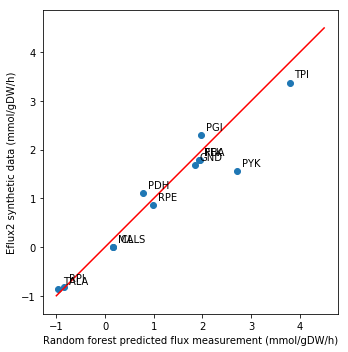

In [19]:
# Plot scatter plot of fluxes
plt.rcParams['figure.figsize'] = (5,5)
plt.scatter(rfArray,eflux2,label=labels)
X_plot = np.linspace(-1, 4.5, 100)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='r')
plt.xlim(-1,3)
plt.axis('equal')
for i in range(len(rfArray)):
    xy = (rfArray[i]+.1,eflux2[i]+.1)
    plt.annotate(labels[i],xy)
plt.xlabel(r'Random forest predicted flux measurement (mmol/gDW/h)')
plt.ylabel(r'Eflux2 synthetic data (mmol/gDW/h)')
plt.tight_layout()
#plt.show()
plt.savefig('nn-eflux2-nudging.pdf')

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462 UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.


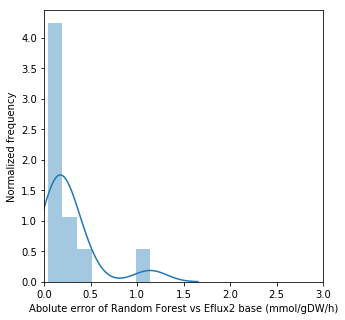

In [20]:
# Histogram plot of errors
g=sns.distplot(absError,hist=True)
plt.xlabel(r'Abolute error of Random Forest vs Eflux2 base (mmol/gDW/h)')
plt.ylabel(r'Normalized frequency')
plt.xlim(0,3)
#plt.show()
plt.savefig('nn-eflux2-nudging-error.pdf')

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462 UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.


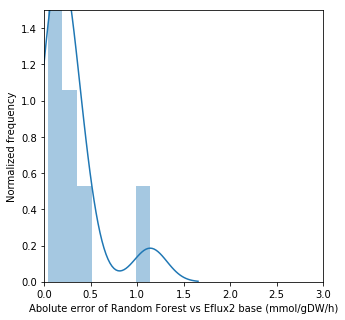

In [21]:
# Zoom of histogram error
g=sns.distplot(absError,hist=True)
plt.xlabel(r'Abolute error of Random Forest vs Eflux2 base (mmol/gDW/h)')
plt.ylabel(r'Normalized frequency')
plt.xlim(0,3)
plt.ylim(0,1.5)
#plt.show()
plt.savefig('nn-eflux2-error-nudging-zoom.pdf')

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462 UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.


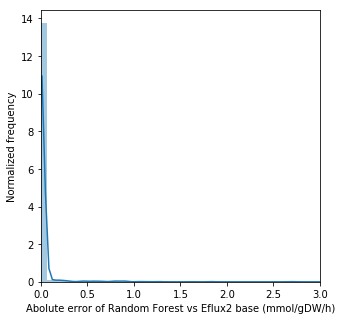

In [22]:
# Histogram plot of all errors
g=sns.distplot(allAbsError,hist=True)
plt.xlabel(r'Abolute error of Random Forest vs Eflux2 base (mmol/gDW/h)')
plt.ylabel(r'Normalized frequency')
plt.xlim(0,3)
#plt.show()
plt.savefig('nn-eflux2-allReactions-nudging-error.pdf')

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462 UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.


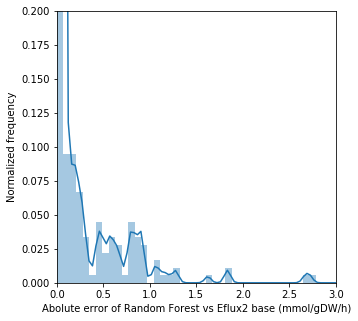

In [23]:
# Zoom of histogram all errors
g=sns.distplot(allAbsError,hist=True)
plt.xlabel(r'Abolute error of Random Forest vs Eflux2 base (mmol/gDW/h)')
plt.ylabel(r'Normalized frequency')
plt.xlim(0,3)
plt.ylim(0,.2)
#plt.show()
plt.savefig('nn-eflux2-allReactions-errornudging--zoom.pdf')